# Digitization with diagonal line removal

Here, we use the same process used in `polygon_digitzation.ipynb` but we add in a section to remove diagonal lines.

In [1]:
import pandas as pd
import os
import rasterio
import numpy as np
from rasterio.mask import mask
from shapely.geometry import box, Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import morphology, feature, measure


In [1]:
# Takes DMS coordinate strings and converts them to decimal degrees
# Handles formats like "35 45" or "-120 07 30" that are found in excel file
def parse_dms(dms_str):
    # Remove any quotes
    dms_str = str(dms_str).strip('"\'')
    
    # Split into parts
    parts = dms_str.split()
    
    # Set defaults
    degrees = 0
    minutes = 0
    seconds = 0
    
    # Parse
    if len(parts) >= 1:
        degrees = float(parts[0])
    if len(parts) >= 2:
        minutes = float(parts[1])
    if len(parts) >= 3:
        seconds = float(parts[2])
    
    # Convert
    decimal = abs(degrees) + minutes/60 + seconds/3600
    return decimal if degrees >= 0 else -decimal

        
# Extract field boundaries from a GeoTIFF, with better diagonal line removal
# to keep rectangular fields intact
def extract_field_boundaries(geotiff_path, output_path=None):
    with rasterio.open(geotiff_path) as src:
        image = src.read()
        transform = src.transform
        crs = src.crs

        # Grayscale
        gray_image = np.mean(image, axis=0)

        # Boost contrast
        p2, p98 = np.percentile(gray_image, (2, 98))
        gray_image = np.interp(gray_image, (p2, p98), (0, 1))

        # Convert to black and white
        binary = gray_image < 0.45

        # Get rid of tiny specks
        cleaned = morphology.remove_small_objects(binary, min_size=200)

        # Remove diagonal connections but keep horizontal and vertical ones
        horizontal = morphology.binary_closing(cleaned, morphology.rectangle(1, 7))
        vertical = morphology.binary_closing(cleaned, morphology.rectangle(7, 1))
        cleaned = np.logical_or(horizontal, vertical)

        # Clean up
        cleaned = morphology.binary_opening(cleaned, morphology.square(3))

        # Find edges
        edges = feature.canny(cleaned, sigma=1.8, low_threshold=0.05, high_threshold=0.25)

        # Make edges thicker and fill gaps
        edges = morphology.dilation(edges, morphology.square(2))
        edges = morphology.closing(edges, morphology.square(5))
        edges = morphology.remove_small_objects(edges, min_size=200)

        # Find contours in the edge image
        contours = measure.find_contours(edges, 0.1)

        polygons = []
        for contour in contours:
            if len(contour) > 8:
                # Close the polygon if almost closed
                start = contour[0]
                end = contour[-1]
                if np.linalg.norm(start - end) < 30:
                    contour = np.vstack([contour, contour[0]])

                # Convert coordinates
                geo_coords = [rasterio.transform.xy(transform, r, c) for r, c in contour]

                try:
                    poly = Polygon(geo_coords)
                    if poly.is_valid and 800 < poly.area < 3e6:
                        poly = poly.simplify(1.0, preserve_topology=True)
                        if poly.is_valid:
                            polygons.append(poly)
                except:
                    continue

        # Put into GeoDataFrame
        gdf = gpd.GeoDataFrame(geometry=polygons, crs=crs)

        # Remove big polygons (field borders)
        large_polys = gdf[gdf.area > 1e6]
        field_polys = gdf[gdf.area <= 1e6]

        # Remove polygons that are inside other polygons (text)
        not_contained = []
        for idx, row in field_polys.iterrows():
            poly1 = row.geometry
            is_contained = any(
                poly2.contains(poly1) for j, poly2 in field_polys.geometry.iteritems() if j != idx
            )
            if not is_contained:
                not_contained.append(poly1)

        # Put the quad polygons back with text filtered out
        all_polygons = not_contained + large_polys.geometry.tolist()

        # New gdf with cleaned polygons
        gdf = gpd.GeoDataFrame(geometry=all_polygons, crs=crs)
        gdf = gdf.buffer(0.8).buffer(-0.8)
        gdf = gpd.GeoDataFrame(geometry=gdf, crs=crs)

        # Smooth out polygons
        if output_path:
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            gdf.to_file(output_path)

        return gdf


# Make polygon edges more rectangular by adjusting vertices
def orthogonalize_polygon(poly, tolerance=12.0):
    if not poly.is_valid:
        return poly
    
    try:
        # Polygon outline
        coords = list(poly.exterior.coords)
        
        # At least 4 points
        if len(coords) < 4:
            return poly
        
        # Check each edge and straighten if it's close to horizontal/vertical
        for i in range(len(coords) - 1):
            current = coords[i]
            next_point = coords[(i + 1) % (len(coords) - 1)]
            
            # Figure out the angle
            dx = next_point[0] - current[0]
            dy = next_point[1] - current[1]
            angle = np.degrees(np.arctan2(dy, dx)) % 360
            
            # See if it's close to 0, 90, 180, or 270 degrees
            min_diff = min(angle % 90, 90 - (angle % 90))
            if min_diff < tolerance:
                # Snap to nearest 90 degree angle
                target_angle = round(angle / 90) * 90
                
                # Keep same length but make it straight
                length = np.sqrt(dx**2 + dy**2)
                rad_angle = np.radians(target_angle)
                new_x = current[0] + length * np.cos(rad_angle)
                new_y = current[1] + length * np.sin(rad_angle)
                
                # Update coordinates
                coords[(i + 1) % (len(coords) - 1)] = (new_x, new_y)
        
        # Make new polygon with the straightened edges
        ortho_poly = Polygon(coords)
        
        # Check
        if ortho_poly.is_valid:
            return ortho_poly
        else:
            # If something went wrong, just return the original
            return poly
    except Exception as e:
        print(f"Error during orthogonalization: {e}")
        return poly

# Plot the shapefile
def plot_with_coordinates(shapefile_path):
    gdf = gpd.read_file(shapefile_path)
    
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # Convert coordinates
    if gdf.crs != 'EPSG:3857':
        gdf = gdf.to_crs(epsg=3857)
    
    gdf.plot(ax=ax, 
            edgecolor='red',
            facecolor='none',
            linewidth=0.5)
    
    ax.grid(True)
    ax.tick_params(labelsize=8)
    
    return fig, ax

# Crops GeoTIFF to coordinates from excel then extracts field boundaries
def crop_and_extract(input_path, output_tif_path, output_shp_path, bounds):
    # Check file actually exists
    if not os.path.exists(input_path):
        print(f"Input file not found: {input_path}")
        return None
        
    # Open source file and print coordinate info
    with rasterio.open(input_path) as src:
        print(f"\nProcessing {os.path.basename(input_path)}:")
        print("Original image bounds:", src.bounds)
        print("Original image CRS:", src.crs)
        
        # Create bounding box
        bbox = box(bounds['west'], bounds['south'], bounds['east'], bounds['north'])
        bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs='EPSG:4326')  # WGS84
        
        # Transform bbox to match crs
        bbox_gdf = bbox_gdf.to_crs(src.crs)
        bbox_transformed = bbox_gdf.geometry.values[0]
        
        print("Transformed crop bounds:", bbox_transformed.bounds)
        
        try:
            # Crop
            out_image, out_transform = mask(src, [bbox_transformed], crop=True)
            
            print("Cropped image shape:", out_image.shape)
            
            # Update metadata
            out_meta = src.meta.copy()
            out_meta.update({
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })
            
            # Output directory
            os.makedirs(os.path.dirname(output_tif_path), exist_ok=True)
            
            # Save cropped image
            with rasterio.open(output_tif_path, "w", **out_meta) as dest:
                dest.write(out_image)
        
        except ValueError as e:
            print(f"Error during cropping: {e}")
            print("Check if the coordinates are within the image bounds and in the correct order.")
            return None
    
    # Extract field boundaries from cropped image
    try:
        gdf = extract_field_boundaries(output_tif_path, output_shp_path)
        return gdf
    except Exception as e:
        print(f"Error during field boundary extraction: {e}")
        return None

# Process GeoTIFF files from the excel sheet
# Has resume capability so you don't have to start over if something goes wrong (processing_results.csv)
def batch_process_geotiffs(excel_path, input_dir=".", output_dir="outputs", resume=True):
    # Make output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Check csv for already processed files
    results_path = os.path.join(output_dir, 'processing_results.csv')
    existing_results = []
    processed_files = set()
    
    if resume and os.path.exists(results_path):
        try:
            results_df = pd.read_csv(results_path)
            existing_results = results_df.to_dict('records')
            
            for result in existing_results:
                if result['status'] == 'Success':
                    processed_files.add(result['file_name'])
            
            print(f"Found {len(processed_files)} previously processed files.")
        except Exception as e:
            print(f"Error reading existing results file: {e}")
    
    # Load excel file
    try:
        df = pd.read_excel(excel_path)
        print(f"Read {len(df)} entries from {excel_path}")
    except Exception as e:
        print(f"Error reading Excel file: {e}")
        return
    
    # Check columns
    required_columns = ["File Name", "South", "North", "West", "East"]
    
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        print(f"Missing required columns in Excel file: {missing_columns}")
        return
    
    # Check if resuming
    results = existing_results.copy() if resume else []
    
    # Keep track how many processed
    processed_count = 0
    
    # Process rows excel file
    for idx, row in df.iterrows():
        file_name = row['File Name']
        
        # Skip if in csv already
        if resume and file_name in processed_files:
            print(f"Skipping already processed file: {file_name}")
            continue
            
        print(f"\n{'='*50}")
        print(f"Processing entry {idx+1}/{len(df)}: {file_name}")
        
        # File paths
        input_file = os.path.join(input_dir, file_name)
        base_name = Path(file_name).stem
        
        # Convert coordinates
        try:
            south = parse_dms(str(row['South']))
            north = parse_dms(str(row['North']))
            west = parse_dms(str(row['West']))
            east = parse_dms(str(row['East']))
            
            print("\nConverted coordinates:")
            print(f"South: {south}")
            print(f"North: {north}")
            print(f"West: {west}")
            print(f"East: {east}")
            
            # Output file paths
            output_tif_path = os.path.join(output_dir, f"{base_name}_cropped.tif")
            output_shp_path = os.path.join(output_dir, f"{base_name}_cropped.shp")
            output_png_path = os.path.join(output_dir, f"{base_name}_cropped.png")
            
            # Bounds
            bounds = {
                'south': south,
                'north': north,
                'west': west,
                'east': east
            }
            
            # Process
            gdf = crop_and_extract(input_file, output_tif_path, output_shp_path, bounds)
            
            status = "Success" if gdf is not None else "Failed"
            
            # Plot
            if gdf is not None:
                fig, ax = plot_with_coordinates(output_shp_path)
                plt.savefig(output_png_path, dpi=300, bbox_inches='tight')
                plt.close()
            
            # Record in csv
            results.append({
                'file_name': file_name,
                'status': status,
                'output_tif': output_tif_path if gdf is not None else None,
                'output_shp': output_shp_path if gdf is not None else None,
                'output_png': output_png_path if gdf is not None else None
            })
            
            processed_count += 1
            
            print(f"Processing status: {status}")
            
            # Save csv after each file
            results_df = pd.DataFrame(results)
            results_df.to_csv(results_path, index=False)
            
        except Exception as e:
            print(f"Error processing {file_name}: {e}")
            results.append({
                'file_name': file_name,
                'status': 'Error',
                'error_message': str(e),
                'output_tif': None,
                'output_shp': None,
                'output_png': None
            })
            # Save progress after errors
            results_df = pd.DataFrame(results)
            results_df.to_csv(results_path, index=False)
    
    # Print summary
    print(f"\n{'='*50}")
    print("Processing Summary:")
    success_count = sum(1 for r in results if r['status'] == 'Success')
    print(f"Total files in Excel: {len(df)}")
    print(f"Previously processed: {len(processed_files)}")
    print(f"Newly processed this run: {processed_count}")
    print(f"Total successful: {success_count}")
    print(f"Total failed: {len(results) - success_count}")
    
    # Save
    results_df = pd.DataFrame(results)
    results_df.to_csv(results_path, index=False)
    print(f"Summary saved to: {results_path}")
    
    return results_df

In [3]:
# Excel file location
excel_path = "excel_map_info/77KN5142.xlsx"
# Geotiff files location
input_dir = "quad_maps/maps_1977"
# Output location
output_dir = "outputs/line_cleaning_test/test_3"
    
# Run the batch processing
results = batch_process_geotiffs(excel_path, input_dir, output_dir, resume=True)

Read 1 entries from excel_map_info/77KN5142.xlsx

Processing entry 1/1: 77KN5142_Poly.tif

Converted coordinates:
South: 35.625
North: 35.75
West: -119.375
East: -119.25

Processing 77KN5142_Poly.tif:
Original image bounds: BoundingBox(left=-6479.924275217612, bottom=-2969.9181592999194, right=6901.444972675919, top=15958.415957300444)
Original image CRS: PROJCS["unnamed",GEOGCS["NAD27",DATUM["North_American_Datum_1927",SPHEROID["Clarke 1866",6378206.4,294.978698213898,AUTHORITY["EPSG","7008"]],AUTHORITY["EPSG","6267"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4267"]],PROJECTION["Polyconic"],PARAMETER["latitude_of_origin",35.625],PARAMETER["central_meridian",-119.3125],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Transformed crop bounds: (-5576.0517363127, 6.644971821084233, 5747.290326157801, 13875.857433848732)
Cropped image sha

/tmp/ipykernel_782868/1608105161.py:104: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  poly2.contains(poly1) for j, poly2 in field_polys.geometry.iteritems() if j != idx


Processing status: Success

Processing Summary:
Total files in Excel: 1
Previously processed: 0
Newly processed this run: 1
Total successful: 1
Total failed: 0
Summary saved to: outputs/line_cleaning_test/test_3/processing_results.csv


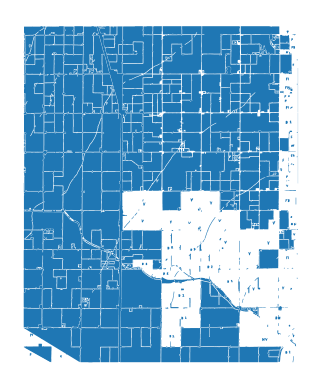

In [4]:
gdf = gpd.read_file("outputs/line_cleaning_test/77KN5142_Poly_cropped.shp")
gdf.plot()
plt.axis('off')
plt.show()